## Model II

* **Norms**: McRae et al. (2005)
* **Model**: Dinu & Lapata (2010) Extension 2
    * Main Idea:
        * The meaning of a target word $t$ is modeled by a distribution over topics $z$.
        * An input "document" to the topic model that produces the distribution of $t$ is generated from $t$'s selected set of contexts $C = \{c_1,...,c_n\}$ and the contexts' frequencies.
        * When the selected contexts are the paradigmatic subjects of $t$, we get a $t$-$z_{subj}$ matrix, when they are the paradigmatic objects of $t$, we get a $t$-$z_{obj}$ matrix.
        * If we were able to compute $p(prop\mid topic)$, then we will be able to obtain a $t$-$prop_{subj}$ matrix and a $t$-$prop_{obj}$ matrix.
        * We can also compute a "general distributional matrix" $t$-$c$ by taking a $[-2,+2]$ word-window (w/ tfidf or PMI conversion).
        * Given a new word $w$, let $t$ be a paradigmatic subject/object of $w$, the similarity of $w$ and $t$ is computed with $SIM(w,t) = \lambda sim_1(w,t) + (1-\lambda) sim_2(w,t)$, where $sim_1$ is computed using the paradigmatic matrix (i.e. $t$-$z_{subj}$ or $t$-$z_{obj}$, depending on whether $w$ and $t$ are paradigmatic subjects/objects), and $sim_2$ is computed using the general distributional matrix $t$-$c$. $\lambda,\lambda\in[0,1]$ be a hyperparameter.
    * Algorithm:
        * [GOAL] = Find a distribution over properties for an input word $w$.
        * For $t$s in a set of selected target words, obtain 3 cooccurrence matrices:
            * $t$-$subj$ matrix: $t$'s paradigmatic subject cohort,
            * $t$-$obj$ matrix, $t$'s paradigmatic object cohort,
            * $t$-$c$ matrix, $t$'s $[-2,+2]$ word-window contexts.
        * Compute paradigmatic matrices as follows:
            * Topic Model using the DL10 "pseudo-documents" using $t$-$subj$ matrix and $t$-$obj$ matrix, producing $t$-$z_{subj}$ matrix and $t$-$z_{obj}$ matrix,
            * Using $p(prop\mid z) = \sum_{c\in topic\,z}p(c\mid z)f(c,prop)$, compute $t$-$prop_{subj}$ matrix and $t$-$prop_{obj}$ matrix.
        * Compute general distributional matrix $t$-$c$ using either tfidf or PMI conversion.
        * Find $w$'s property distribution (**NB: Modified Later to Incorporate Katrin's Model. For detail see last section**).
    * Similarity Functions:
        * $Cosine(w,t) = \frac{w\cdot t}{|w||t|}$.
        * $SKLD(w,t) = \frac{1}{2}\left(\sum_iw(i)log\frac{w(i)}{t(i)} + \sum_it(i)log\frac{t(i)}{w(i)}\right)$, (cf. Griffiths & Steyvers 2004:10(5)).
    * Property Indicator Functions:
        * $f_{binary}(c,prop) = \begin{cases}1 & \text{if context word has prop}\\ 0 & \text{otherwise}\end{cases}$.
        * $f_{stochastic}(c,prop) = wgt(t,prop) = \frac{production\_freq(w)}{30}$ (computed from McRae data).

## 0. Norms

### A. Load Norms

In [1]:
import pandas as pd

In [2]:
data_path = "/Users/jacobsw/Desktop/CODER/IMPLEMENTATION_CAMP/BASIC_TOPICS/DISTRIBUTIONAL_SEMANTICS/DATA/McRae-BRM-InPress/"

In [3]:
df = pd.read_csv(data_path+"CONCS_FEATS_concstats_brm.xls", delimiter='\t')

In [4]:
print df.columns

Index([u'Concept', u'Feature', u'WB_Label', u'WB_Maj', u'WB_Min', u'BR_Label',
       u'Prod_Freq', u'Rank_PF', u'Sum_PF_No_Tax', u'CPF', u'Disting',
       u'Distinct', u'CV_No_Tax', u'Intercorr_Str_Tax',
       u'Intercorr_Str_No_Tax', u'Feat_Length_Including_Spaces', u'Phon_1st',
       u'KF', u'ln(KF)', u'BNC', u'ln(BNC)', u'Familiarity', u'Length_Letters',
       u'Length_Phonemes', u'Length_Syllables', u'Bigram', u'Trigram',
       u'ColtheartN', u'Num_Feats_Tax', u'Num_Feats_No_Tax',
       u'Num_Disting_Feats_No_Tax', u'Disting_Feats_%_No_Tax',
       u'Mean_Distinct_No_Tax', u'Mean_CV_No_Tax', u'Density_No_Tax',
       u'Num_Corred_Pairs_No_Tax', u'%_Corred_Pairs_No_Tax', u'Num_Func',
       u'Num_Vis_Mot', u'Num_VisF&S', u'Num_Vis_Col', u'Num_Sound',
       u'Num_Taste', u'Num_Smell', u'Num_Tact', u'Num_Ency', u'Num_Tax'],
      dtype='object')


In [5]:
df.head(20)

,Concept,Feature,WB_Label,WB_Maj,WB_Min,BR_Label,Prod_Freq,Rank_PF,Sum_PF_No_Tax,CPF,...,Num_Func,Num_Vis_Mot,Num_VisF&S,Num_Vis_Col,Num_Sound,Num_Taste,Num_Smell,Num_Tact,Num_Ency,Num_Tax
0,accordion,a_musical_instrument,superordinate,c,h,taxonomic,28,1,NaN,18,...,2,0,2,0,2,0,0,0,2,1
1,accordion,associated_with_polkas,associated_entity,s,e,encyclopaedic,9,4,9.0,1,...,2,0,2,0,2,0,0,0,2,1
2,accordion,has_buttons,external_component,e,ce,visual-form_and_surface,8,5,163.0,13,...,2,0,2,0,2,0,0,0,2,1
3,accordion,has_keys,external_component,e,ce,visual-form_and_surface,17,2,108.0,7,...,2,0,2,0,2,0,0,0,2,1
4,accordion,inbeh_-_produces_music,entity_behavior,e,b,sound,6,7,178.0,13,...,2,0,2,0,2,0,0,0,2,1
5,accordion,is_loud,external_surface_property,e,se,sound,6,7,317.0,34,...,2,0,2,0,2,0,0,0,2,1
6,accordion,requires_air,contingency,i,c,encyclopaedic,11,3,49.0,4,...,2,0,2,0,2,0,0,0,2,1
7,accordion,used_by_moving_bellows,action,s,a,function,8,5,8.0,1,...,2,0,2,0,2,0,0,0,2,1
8,accordion,worn_on_chest,function,s,f,function,6,7,6.0,1,...,2,0,2,0,2,0,0,0,2,1
9,airplane,beh_-_flies,entity_behavior,e,b,visual-motion,25,1,712.0,46,...,3,3,5,0,0,0,0,0,2,0


### B. Build Token-Lemma Lookup

In [6]:
from nltk.corpus import brown
from spacy.en import English

In [7]:
parser = English()

In [8]:
brown_sents = [unicode(' '.join(sent)) for sent in brown.sents()]

In [9]:
%%time
parsed_sents = [parser(sent) for sent in brown_sents]

CPU times: user 1min 36s, sys: 1.06 s, total: 1min 37s
Wall time: 1min 37s


In [10]:
def make_token2lemma_dict(parsed_sents):
    
    lemmas = set()
    token2lemma = {}
    for parsed_sent in parsed_sents:
        for token in parsed_sent:
            token2lemma[token.orth_] = token.lemma_
            lemmas.add(token.lemma_)
    
    return lemmas, token2lemma

In [11]:
%%time
brown_lemmas, brown_t2l = make_token2lemma_dict(parsed_sents)

CPU times: user 1.39 s, sys: 63.2 ms, total: 1.46 s
Wall time: 1.44 s


In [12]:
print brown_t2l['books']

book


### C. Build Norm-Feature Lookup

In [13]:
norms = {df.ix[i]['Concept'] for i in range(df.shape[0])}
features = {df.ix[i]['Feature'] for i in range(df.shape[0])}

In [14]:
def norm_normalize(norm):
    
    norm = norm.split('_')[0] if '_' in norm else norm
    if norm in brown_t2l: return brown_t2l[norm]
    return norm


In [15]:
print norm_normalize('cat_(kitchen)')
print norm_normalize('cat')

cat
cat


In [16]:
# Count Out-Of-Vocab Norms For Brown
t = [] 
for norm in norms:
    norm = norm.split('_')[0] if '_' in norm else norm
    if norm in brown_lemmas or norm in brown_t2l: continue
    t.append(norm)

In [17]:
print t
print len(t)

['earmuffs', 'bike', 'screwdriver', 'unicycle', 'camisole', 'crossbow', 'hamster', 'bra', 'sledgehammer', 'skateboard', 'leotards', 'rhubarb', 'platypus', 'pelican', 'minnow', 'canary', 'spatula', 'motorcycle', 'iguana', 'chickadee', 'giraffe', 'tricycle', 'bazooka', 'tomahawk', 'ostrich', 'cucumber', 'lettuce', 'whale', 'stork', 'bluejay', 'colander', 'chipmunk', 'escalator', 'partridge', 'parka', 'zucchini', 'dunebuggy', 'machete', 'crowbar', 'housefly', 'blender', 'nectarine', 'scooter', 'cougar', 'penguin', 'emu', 'honeydew', 'wheelbarrow', 'harmonica', 'eggplant', 'groundhog', 'harpoon', 'yam', 'squid', 'toaster', 'moose', 'tuna', 'surfboard', 'nylons', 'raven', 'budgie', 'fridge', 'gopher', 'flamingo', 'sleigh', 'trombone', 'strainer', 'dagger', 'chimp', 'buzzard', 'guppy', 'grater', 'nightgown', 'cello', 'hornet', 'finch', 'tangerine', 'gorilla', 'caribou']
79


In [18]:
from collections import defaultdict

In [19]:
def make_norm2feature_dict(df):
    
    norm2feature = defaultdict(int)
    for i in xrange(df.shape[0]):
        norm = norm_normalize(df.ix[i]['Concept'])
        prop = df.ix[i]['Feature']
        norm2feature[(norm,prop)] = df.ix[i]['Prod_Freq'] # production frequency.
    
    return norm2feature

In [20]:
print df.ix[0]['Concept']
print df.ix[0]['Feature']
print df.ix[0]['Prod_Freq']

accordion
a_musical_instrument
28


In [21]:
%%time
norm2feature = make_norm2feature_dict(df)

CPU times: user 4.36 s, sys: 69.7 ms, total: 4.43 s
Wall time: 4.46 s


In [22]:
for prop in features:
    count = norm2feature[('airplane',prop)]
    if count!=0: print prop, count

used_for_transportation 10
is_fast 11
used_for_travel 7
has_a_propeller 5
has_wings 20
beh_-_flies 25
is_large 8
requires_pilots 11
has_engines 5
used_for_passengers 15
found_in_airports 8
made_of_metal 8
inbeh_-_crashes 7


## I. Compute Cooccurrence Matrices

### A. Build Cooccurrence Matrix I: General Distributional Matrix $t$-$c$

In [23]:
from collections import Counter
from string import punctuation as punc
from spacy.en import STOPWORDS

In [24]:
brown_fdist = Counter(list(brown.words()))

In [25]:
norms = set(map(lambda norm:norm_normalize(norm), norms)) # faster lookup.

In [26]:
stopwords = STOPWORDS
stopwords.add('``'); stopwords.add("''")

In [27]:
def tokensent2lemmasent(parsed_sents, fdist, norms, freq=20):
    
    sents_in_lemmas = []
    for parsed_sent in parsed_sents:
        sent = []
        for token in parsed_sent:
            if token.orth_ in norms or token.lemma_ in norms:
                sent.append(token.lemma_)
            elif fdist[token.orth_] < freq \
                or token.lemma_ in STOPWORDS \
                or token.lemma_ in punc: continue
            else: 
                sent.append(token.lemma_)
        sents_in_lemmas.append(sent)
    
    return sents_in_lemmas

In [28]:
%%time
brown_lemmasents = tokensent2lemmasent(parsed_sents, brown_fdist, norms)

CPU times: user 2 s, sys: 22.5 ms, total: 2.02 s
Wall time: 2.02 s


In [29]:
vocab = {word for sent in brown_lemmasents for word in sent}

In [30]:
len(vocab)

3988

In [31]:
import numpy as np

In [32]:
def build_cooccurrence_matrix(sents, vocab, win_size):
    
    w2i = {w:i for i,w in enumerate(vocab)}
    i2w = {i:w for i,w in enumerate(vocab)}
    print "... building dictionary"
    cooccurrence_dict = defaultdict(int)
    for sent in sents:
        for i,target in enumerate(sent):
            contexts = sent[max(0,i-win_size):i] + sent[min(i+1,len(sent)):min(i+1+win_size,len(sent))]
            for context in contexts:
                cooccurrence_dict[(target,context)] += 1
    print "... building cooccurrence matrix"
    cooccurrence_matrix = np.zeros((len(vocab),len(vocab)))
    for target in vocab:
        for context in vocab:
            cooccurrence_matrix[w2i[target]][w2i[context]] += cooccurrence_dict[(target,context)]
    
    return w2i, i2w, cooccurrence_matrix

In [33]:
%%time
w2i, i2w, t2c_mat = build_cooccurrence_matrix(brown_lemmasents, vocab, 2)

... building dictionary
... building cooccurrence matrix
CPU times: user 26.8 s, sys: 2.09 s, total: 28.9 s
Wall time: 29.2 s


In [34]:
w2i['cat']

1190

In [35]:
t2c_mat[1190].sum()

136.0

### B. Build Cooccurrence Matrix II: Paradigmatic Matrix $t$-$subj$ & $t$-$obj$

In [36]:
def extract_dep_triples(parsed_sents):
    
    triples = []
    for parsed_sent in parsed_sents:
        for token in parsed_sent:
            lemma_triple = (token.lemma_, token.dep_, token.head.lemma_)
            triples.append(lemma_triple)
    
    return triples

In [37]:
%%time
dep_triples = extract_dep_triples(parsed_sents)

CPU times: user 953 ms, sys: 188 ms, total: 1.14 s
Wall time: 1.14 s


In [38]:
# get subj/obj vocabs
def get_arg_set(triples, argtype): # argtype = {subj, obj}
    
    arg_set = set()
    for triple in triples:
        if triple[1].endswith(argtype):
            arg_set.add(triple[0])
    
    return arg_set


In [39]:
%%time
subj_set, obj_set = get_arg_set(dep_triples, 'subj'), get_arg_set(dep_triples, 'obj')

CPU times: user 918 ms, sys: 12.3 ms, total: 930 ms
Wall time: 927 ms


In [40]:
print len(subj_set)
print len(obj_set)

8729
16274


In [41]:
# get N:[v1...vn] dict
def get_pred_list(triples, argtype): # argtype = {subj, obj}
    
    pred_list = defaultdict(list)
    for triple in triples:
        if triple[1].endswith(argtype):
            pred_list[triple[0]].append(triple[2])
    
    return pred_list


In [42]:
%%time
subj2pred, obj2pred = get_pred_list(dep_triples, 'subj'), get_pred_list(dep_triples, 'obj')

CPU times: user 1.02 s, sys: 18.8 ms, total: 1.04 s
Wall time: 1.04 s


In [43]:
print subj2pred['cat']
print obj2pred['cat']

[u'be', u'come', u'out', u'be', u'complement', u'be', u'go', u'meet', u'manage']
[u'for', u'like', u'feed', u'have', u'put', u'as', u'like', u'like', u'like', u'to', u'at', u'like', u'like', u'like', u'watch', u'dye', u'of', u'send']


In [44]:
def build_para_matrix(pred_list, vocab): # pred_list: dict; vocab: list
    
    w2i = {w:i for i,w in enumerate(vocab)}
    i2w = {i:w for i,w in enumerate(vocab)}
    para_matrix = np.zeros((len(vocab),len(vocab)))
    for i,wi in enumerate(vocab):
        if i!=0 and i%1000==0: print "... processed %d words." % i
        for wj in vocab:
            if wi==wj: continue
            for pred in pred_list[wi]: # if wi has v*3, wj has v*2, then wiwj cell = 3*2 = 6 <= "paradigmatic weight"
                para_matrix[w2i[wi]][w2i[wj]] += pred_list[wj].count(pred)
    
    return w2i, i2w, para_matrix
    

In [156]:
%%time
w2i_subj, i2w_subj, subj_para_mat = build_para_matrix(subj2pred, list(subj_set)) # expected: 8~9 mins

... processed 1000 words.
... processed 2000 words.
... processed 3000 words.
... processed 4000 words.
... processed 5000 words.
... processed 6000 words.
... processed 7000 words.
... processed 8000 words.
CPU times: user 15min 41s, sys: 3.99 s, total: 15min 45s
Wall time: 15min 46s


In [163]:
%%time
w2i_obj, i2w_obj, obj_para_mat = build_para_matrix(obj2pred, list(obj_set)) # expected: 16~17 mins

... processed 1000 words.
... processed 2000 words.
... processed 3000 words.
... processed 4000 words.
... processed 5000 words.
... processed 6000 words.
... processed 7000 words.
... processed 8000 words.
... processed 9000 words.
... processed 10000 words.
... processed 11000 words.
... processed 12000 words.
... processed 13000 words.
... processed 14000 words.
... processed 15000 words.
... processed 16000 words.
CPU times: user 57min 48s, sys: 19.8 s, total: 58min 8s
Wall time: 58min 7s


In [45]:
import cPickle

In [48]:
# %%time
path = "/Users/jacobsw/Desktop/UNIV/FALL_2016/LIN389C_RSCH_COMPLING/BAYESIAN/CODE_DRAFTS/DATA/"
# cPickle.dump((w2i_subj,i2w_subj,subj_para_mat), open(path+"subj_para_mat.p",'wb'))
# cPickle.dump(obj_para_mat, open(path+"obj_para_mat.p",'wb'))
# w2i_subj,i2w_subj,subj_para_mat = cPickle.load(open(path+"subj_para_mat.p",'rb'))
# w2i_obj,i2w_obj,obj_para_mat = cPickle.load(open(path+"obj_para_mat.p",'rb'))

## III. Topic Modeling

In [46]:
from gensim import corpora
from gensim.models.ldamodel import LdaModel

In [47]:
class TopicModel:
    
    def __init__(self, documents, num_topics=100, num_iters=5):
        dic = corpora.Dictionary(documents)
        documents = [dic.doc2bow(document) for document in documents]
        self.documents = documents
        self.lda = LdaModel(documents, num_topics=num_topics, id2word=dic, passes=num_iters)
    
    def summarize(self, num_topics=100, num_words=5):
        freq_stats = self.lda.print_topics(num_topics=num_topics, num_words=num_words)
        print "Statistics"
        print 
        for i,document in enumerate(self.documents):
            print "Most %d-Frequent Words in Topic %d:" % (num_words,freq_stats[i][0])
            print freq_stats[i][1]
            print "Topic-Distribution:"
            print self.lda.get_document_topics(document)
            print

In [54]:
def make_fake_documents(matrix, vocab):
    
    docs = []
    m, n = matrix.shape
    for i in xrange(m):
        if i!=0 and i%1000==0: print "... processed %d targets." % i
        doc = []
        for j in xrange(n): 
            doc += [vocab[j]] * matrix[i][j]
        docs.append(doc)
    
    return docs

In [170]:
%%time
general_docs = make_fake_documents(t2c_mat, i2w)

... processed 1000 targets.
... processed 2000 targets.
... processed 3000 targets.
CPU times: user 29.5 s, sys: 1.07 s, total: 30.5 s
Wall time: 30.1 s


In [178]:
%%time
subj_docs = make_fake_documents(subj_para_mat, i2w_subj)

... processed 1000 targets.
... processed 2000 targets.
... processed 3000 targets.
... processed 4000 targets.
... processed 5000 targets.
... processed 6000 targets.
... processed 7000 targets.
... processed 8000 targets.
CPU times: user 2min 34s, sys: 5.76 s, total: 2min 40s
Wall time: 2min 38s


In [179]:
%%time
obj_docs = make_fake_documents(obj_para_mat, i2w_obj)

... processed 1000 targets.
... processed 2000 targets.
... processed 3000 targets.
... processed 4000 targets.
... processed 5000 targets.
... processed 6000 targets.
... processed 7000 targets.
... processed 8000 targets.
... processed 9000 targets.
... processed 10000 targets.
... processed 11000 targets.
... processed 12000 targets.
... processed 13000 targets.
... processed 14000 targets.
... processed 15000 targets.
... processed 16000 targets.
CPU times: user 8min 52s, sys: 26 s, total: 9min 18s
Wall time: 9min 15s


In [55]:
%%time
# cPickle.dump((general_docs, subj_docs, obj_docs), open(path+"fake_general_subj_obj_documents.p",'wb'))
# general_docs, subj_docs, obj_docs = cPickle.load(open(path+"fake_general_subj_obj_documents.p",'rb'))

In [56]:
%%time
tm_general = TopicModel(general_docs, num_topics=100, num_iters=5)

CPU times: user 2min 6s, sys: 2.21 s, total: 2min 9s
Wall time: 2min 8s


In [63]:
%%time
tm_subj = TopicModel(subj_docs, num_topics=100, num_iters=5)

CPU times: user 17min 13s, sys: 1min 12s, total: 18min 25s
Wall time: 16min 43s


In [64]:
%%time
tm_obj = TopicModel(obj_docs, num_topics=100, num_iters=5)

CPU times: user 1h 6min 37s, sys: 6min, total: 1h 12min 37s
Wall time: 1h 3min 20s


In [49]:
# %%time
# cPickle.dump((tm_general, tm_subj, tm_obj), open(path+"general_subj_obj_topic_model.p",'wb'))
# tm_general, tm_subj, tm_obj = cPickle.load(open(path+"general_subj_obj_topic_model.p",'rb'))

## IV. Words As Distributions Over Properties

* Probability of Property Given Topic:
    * $p(prop\mid z) = \sum_{c\in topic\,z}p(c\mid z)f(c,prop)$
    
    
* Property Indicator Functions:
    * $f_{binary}(c,prop) = \begin{cases}1 & \text{if context word has prop}\\ 0 & \text{otherwise}\end{cases}$.
    * $f_{stochastic}(c,prop) = wgt(c,prop) = \frac{production\_freq(w)}{30}$ (computed from McRae data).
    
    
* Target-Property Matrices
    * Let $T, Z, P$ be the vocabularies of target words, topics, and properties respectively,
    * $M_{|T|\times |P|} = A_{|T|\times |Z|}\cdot B_{|Z|\times |P|}$

### A. Distribution Over Properties for Topics

In [50]:
def make_topic_word_dict(lda, ntopics=100):
    
    nwords = lda.num_terms
    i2w = lda.id2word
    topicword_dict = defaultdict(float)
    for i in xrange(ntopics):
        for w_id,prob in lda.get_topic_terms(i,topn=nwords):
            topicword_dict[(i,i2w[w_id])] = prob
    
    return topicword_dict

def p_word_given_topic(topicword_dict, word, topic):
    
    return topicword_dict[(topic,word)]

def f_word_prop_bi(word, prop):
    
    return 1 if norm2feature[(word,prop)] else 0

def f_word_prop_stc(word, prop):
    
    return norm2feature[(word,prop)] / 30.

In [51]:
%%time
general_topicword_dict = make_topic_word_dict(tm_general.lda)

CPU times: user 701 ms, sys: 130 ms, total: 831 ms
Wall time: 994 ms


In [52]:
%%time
subj_topicword_dict = make_topic_word_dict(tm_subj.lda)

CPU times: user 1.57 s, sys: 269 ms, total: 1.84 s
Wall time: 1.95 s


In [53]:
%%time
obj_topicword_dict = make_topic_word_dict(tm_obj.lda)

CPU times: user 3.2 s, sys: 525 ms, total: 3.72 s
Wall time: 3.95 s


In [54]:
print p_word_given_topic(general_topicword_dict, 'cat', 0)
print p_word_given_topic(subj_topicword_dict, 'cat', 0)
print p_word_given_topic(obj_topicword_dict, 'cat', 0)

1.93929531407e-06
0.00024524160111
2.03681198576e-05


In [55]:
print "Binary:"
print f_word_prop_bi('accordion','a_musical_instrument')
print f_word_prop_bi('accordion','has_buttons')
print "Stochastic:"
print f_word_prop_stc('accordion','a_musical_instrument')
print f_word_prop_stc('accordion','has_buttons')

Binary:
1
1
Stochastic:
0.933333333333
0.266666666667


In [56]:
def make_topic_prop_dict(lda, topicword_dict, f=f_word_prop_stc, ntopics=100):
    
    nwords = lda.num_terms
    i2w = lda.id2word
    topicprop_dict = defaultdict(float)
    for i in xrange(ntopics):
        if i!=0 and i%5==0: print "... processed %d topics." % i
        for prop in features: # features defined at the top.
            ret = 0.0
            for c_id,prob in lda.get_topic_terms(i,topn=nwords):
                c = i2w[c_id]
                ret += p_word_given_topic(topicword_dict,c,i)*f(c,prop)
            topicprop_dict[(i,prop)] = ret
    
    return topicprop_dict


In [97]:
%%time
subj_topicprop_dict = make_topic_prop_dict(tm_subj.lda, subj_topicword_dict)

... processed 5 topics.
... processed 10 topics.
... processed 15 topics.
... processed 20 topics.
... processed 25 topics.
... processed 30 topics.
... processed 35 topics.
... processed 40 topics.
... processed 45 topics.
... processed 50 topics.
... processed 55 topics.
... processed 60 topics.
... processed 65 topics.
... processed 70 topics.
... processed 75 topics.
... processed 80 topics.
... processed 85 topics.
... processed 90 topics.
... processed 95 topics.
CPU times: user 1h 36min 6s, sys: 1min 51s, total: 1h 37min 58s
Wall time: 1h 38min 53s


In [99]:
%%time
obj_topicprop_dict = make_topic_prop_dict(tm_obj.lda, obj_topicword_dict)

... processed 5 topics.
... processed 10 topics.
... processed 15 topics.
... processed 20 topics.
... processed 25 topics.
... processed 30 topics.
... processed 35 topics.
... processed 40 topics.
... processed 45 topics.
... processed 50 topics.
... processed 55 topics.
... processed 60 topics.
... processed 65 topics.
... processed 70 topics.
... processed 75 topics.
... processed 80 topics.
... processed 85 topics.
... processed 90 topics.
... processed 95 topics.
CPU times: user 3h 15min 25s, sys: 7min 12s, total: 3h 22min 37s
Wall time: 3h 25min 18s


In [57]:
# cPickle.dump(subj_topicprop_dict, open(path+"subj_topicprop_dict.p",'wb'))
# cPickle.dump(obj_topicprop_dict, open(path+"obj_topicprop_dict.p",'wb'))
# subj_topicprop_dict = cPickle.load(open(path+"subj_topicprop_dict.p",'rb'))
# obj_topicprop_dict = cPickle.load(open(path+"obj_topicprop_dict.p",'rb'))

In [66]:
import matplotlib.pyplot as plt
%matplotlib inline

In [101]:
def plot_prop_distribution(topic,topk=5):
    props = []
    probs = []
    for key,value in subj_topicprop_dict.iteritems():
        if key[0]==topic:
            props.append(key[1]); probs.append(value)
    top_props_idx = np.argsort(probs)[::-1][:topk]
    for i,idx in enumerate(top_props_idx):
        print "%dth Property: %s (prop=%.6f%%)" % (i+1,props[idx],probs[idx])
    plt.plot(probs)
    plt.show()

1th Property: made_of_metal (prop=0.001697%)
2th Property: made_of_wood (prop=0.001680%)
3th Property: is_large (prop=0.001419%)
4th Property: used_for_transportation (prop=0.000924%)
5th Property: has_wheels (prop=0.000888%)


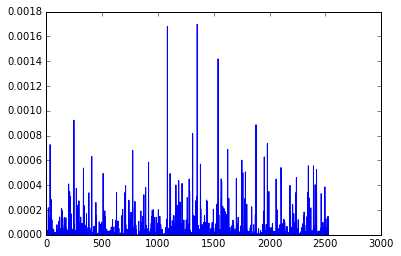

In [102]:
plot_prop_distribution(0)

### B. Make Normalized $target-topic$ Matrices

** i.e. probability distributions, for each target word, of topics. **

In [138]:
from __future__ import division

In [140]:
def normalize_matrix(mat):
    
    return np.apply_along_axis(lambda r: r/sum(r), 1, mat)


In [141]:
def make_word_topic_matrix(lda):
    
    nwords, ntopics = lda.num_terms, lda.num_topics
    word2topic_mat = np.zeros((nwords,ntopics))
    for i in xrange(ntopics):
        for w_id,prob in lda.get_topic_terms(i,topn=nwords):
            word2topic_mat[w_id][i] = prob
    
    return normalize_matrix(word2topic_mat)

In [142]:
%%time
general_word2topic_mat = make_word_topic_matrix(tm_general.lda)

CPU times: user 383 ms, sys: 6.45 ms, total: 389 ms
Wall time: 388 ms


In [145]:
%%time
subj_word2topic_mat = make_word_topic_matrix(tm_subj.lda)

CPU times: user 877 ms, sys: 133 ms, total: 1.01 s
Wall time: 1.01 s


In [146]:
%%time
obj_word2topic_mat = make_word_topic_matrix(tm_obj.lda)

CPU times: user 1.7 s, sys: 211 ms, total: 1.91 s
Wall time: 1.92 s


### C. Make Normalized $topic-prop$ Matrices

In [148]:
def make_topic_prop_matrix(topicprop_dict, ntopics=100):
    
    topic2prop_mat = np.zeros((ntopics,len(features))) # features defined earlier
    for i in xrange(ntopics):
        for j,prop in enumerate(features):
            topic2prop_mat[i][j] = topicprop_dict[(i,prop)]
    
    return normalize_matrix(topic2prop_mat) 

# note that the assumptions is that only subj/obj property distributions make sense.
# specifically, we don't want to say that because "cat" appears in "cat sat on a mat", it somehow
# has the properties of a "mat".

In [149]:
%%time
subj_topic2prop_mat = make_topic_prop_matrix(subj_topicprop_dict)

CPU times: user 245 ms, sys: 27 ms, total: 272 ms
Wall time: 260 ms


In [150]:
%%time
obj_topic2prop_mat = make_topic_prop_matrix(obj_topicprop_dict)

CPU times: user 255 ms, sys: 39.7 ms, total: 294 ms
Wall time: 284 ms


### D. Finalize -- Compute $target-prop$ Matrices (Subj/Obj Only)

In [155]:
%%time
subj_word2prop_mat = np.dot(subj_word2topic_mat,subj_topic2prop_mat)

CPU times: user 308 ms, sys: 59.7 ms, total: 367 ms
Wall time: 162 ms


In [156]:
%%time
obj_word2prop_mat = np.dot(obj_word2topic_mat,obj_topic2prop_mat)

CPU times: user 647 ms, sys: 121 ms, total: 769 ms
Wall time: 326 ms


In [157]:
print subj_word2prop_mat.shape
print obj_word2prop_mat.shape

(8616, 2526)
(16196, 2526)


In [108]:
print w2i['cat'], w2i_subj['cat'], w2i_obj['cat']

1190 2762 5144


In [109]:
print t2c_mat.shape, subj_para_mat.shape, obj_para_mat.shape

(3988, 3988) (8729, 8729) (16274, 16274)


In [112]:
print t2c_mat[1190].sum(), subj_para_mat[1190].sum(), obj_para_mat[1190].sum()

136.0 1.0 9.0


## V. Compute Similarity

### A. Cosine

* $Cosine(w,t) = \frac{w\cdot t}{|w||t|}$.

In [165]:
def cosine(x, y):
    return x.dot(y) / (np.linalg.norm(x)*np.linalg.norm(y))


In [170]:
def sim_cosine(w, t, mode): # mode: genenral, subj, obj
    
    if mode=='subj':
        return cosine(subj_word2prop_mat[w2i[w]],subj_word2prop_mat[w2i[t]])
    elif mode=='obj':
        return cosine(obj_word2prop_mat[w2i[w]],obj_word2prop_mat[w2i[t]])
    else: 
        return cosine(general_word2topic_mat[w2i[w]],general_word2topic_mat[w2i[t]])

In [177]:
print sim_cosine('cat','dog','general')
print sim_cosine('cat','dog','subj')
print sim_cosine('cat','dog','obj')

0.255002191852
0.9998739764
0.999805562048


### B. SKLD

* $SKLD(w,t) = \frac{1}{2}\left(\sum_iw(i)log\frac{w(i)}{t(i)} + \sum_it(i)log\frac{t(i)}{w(i)}\right)$, (cf. Griffiths & Steyvers 2004:10(5)).

In [197]:
def log(x): return np.log(x) if x!=0 else np.log(1e-20)
def div(x,y): return x/y if y!=0 else 1e10

In [198]:
def kld(w, t):
    
    return sum(w_i*log(div(w_i,t_i)) for w_i,t_i in zip(w,t))

def skld(w, t):
    
    return .5 * (kld(w,t) + kld(t,w))

In [199]:
def sim_skld(w, t, mode):
    
    if mode=='subj':
        return skld(subj_word2prop_mat[w2i[w]],subj_word2prop_mat[w2i[t]])
    elif mode=='obj':
        return skld(obj_word2prop_mat[w2i[w]],obj_word2prop_mat[w2i[t]])
    else: 
        return skld(general_word2topic_mat[w2i[w]],general_word2topic_mat[w2i[t]])

In [200]:
print sim_skld('cat','dog','general')
print sim_skld('cat','dog','subj')
print sim_skld('cat','dog','obj')

1.84274016857
0.00201145877196
0.00163546484176


### C. Overall Similarity

* $SIM(w,t) = \lambda sim_1(w,t) + (1-\lambda) sim_2(w,t)$

In [201]:
def sim(w, t, mode, sim_func=sim_skld, lmd=.8):
    
    return lmd * sim_func(w,t,mode) + lmd * sim_func(w,t,'general')

In [210]:
def sim_summary(w, t, lmds):
    
    for lmd in lmds:
        print "lmd=%.1f" % lmd
        print "%s, %s: subj sim=%.6f" % (w,t,sim(w,t,'subj',lmd=lmd))
        print "%s, %s: obj sim=%.6f" % (w,t,sim(w,t,'obj',lmd=lmd))
        print 

In [215]:
sim_summary('crocodile', 'alligator', [.1,.5,.8])

lmd=0.1
crocodile, alligator: subj sim=0.287984
crocodile, alligator: obj sim=0.294597

lmd=0.5
crocodile, alligator: subj sim=1.439921
crocodile, alligator: obj sim=1.472986

lmd=0.8
crocodile, alligator: subj sim=2.303874
crocodile, alligator: obj sim=2.356778



In [214]:
sim_summary('accordion', 'alligator', [.1,.5,.8])

lmd=0.1
accordion, alligator: subj sim=0.221243
accordion, alligator: obj sim=0.221054

lmd=0.5
accordion, alligator: subj sim=1.106214
accordion, alligator: obj sim=1.105272

lmd=0.8
accordion, alligator: subj sim=1.769943
accordion, alligator: obj sim=1.768434



## VI. What's the Probability Distriubiton of New Word $w$ Which is Observed in Sentence $s$

* Model:
    * $d(w) = f(c(w),g(w),l(s))$,
    * $d(w)$: Learned property distribution; $c(w)$: Prior property distribution; $g(w)$: Properties from ground information; $l(s)$: learned property distribution based on contextual information.
    * $d(w) = p(\theta\mid w) = \frac{1}{Z}p(w\mid \theta)p(\theta)$, i.e. the posterior distribution of properties, where $\theta$ is the parameter of the distribution, $Z$ is the normalizing constant $\int_\Theta p(w\mid \theta_i)p(\theta_i), \Theta = \{\theta_1,...,\theta_i,...,\theta_{|P|}\}$ ($P$ is the set of properties).

* General Algorithm:
    * Set $c(w)$ as 
        * Case 1: $w$ unknown, a uniform distribution over properties,
        * Case 2: $w$ known, $w$'s distribution over properties
    * Set $g(w)$ as a list of observed properties,
    * Compute $l(s)$: Using the predicate $v$ of the sentence, find $w$'s cohort (either subject/object) $T$, then
        * If $w$ is known, 
            * For $t\in T$, compute $\lambda sim_1(w,t) + (1-\lambda) sim_2(w,t)$.
            * $w$'s learned property distribution $l(s) = normalize(\prod_{t\in T}SIM(w,t)\cdot\theta_t)$ (pointwise multiplication, $SIM(w,t)$ can be seen as the weighting, i.e. $t$'s relative importance to $w$).
        * Otherwise, 
            * $w$'s learned property distribution $l(s) = normalize(\prod_{t\in T}\theta_t)$ (i.e. treating cohort members as equally important).
    * Compute $d(w)$:
        * Case 1: $g(w)=\emptyset$, 
            * Perform pointwise multiplication of $c(w)$ and $l(s)$, then normalize,
            * Reture the top $k$ most likely properties.
        * Case 2: $g(w)\neq\emptyset$, 
            * Perform the same operation as in Case 1,
            * Return in addition the properties in $g(w)$ (**TODO**: This is only for the single-exposure method. For multiple-exposure method, we'd like to incorporate $g(w)$ in the distribution $d(w)$ somehow).
            
* ** Current Demo **:
    * $w$ is known or unknown,
    * $g(w)$ is empty.

* Bayesian Update:
    * At each exposure to a sentence $s$ containing $w$, update $c(w)$ with $d(w)$
    

### A. Facilities

In [231]:
def normalize_vector(vec):
    
    return vec / vec.sum()

In [250]:
P = features
features_list = list(features)

In [234]:
def c(w):
    vec = np.ones(len(P))
    return normalize_vector(vec)

In [235]:
print c('cat'), len(c('cat'))

[ 0.00039588  0.00039588  0.00039588 ...,  0.00039588  0.00039588
  0.00039588] 2526


In [224]:
# get V:[n1...nn] dict, i.e. for paradigmatic cohort
def get_arg_list(triples, argtype): # argtype = {subj, obj}
    
    arg_list = defaultdict(list)
    for triple in triples:
        if triple[1].endswith(argtype):
            arg_list[triple[2]].append(triple[0])
    
    return arg_list

In [225]:
%%time
subj2args, obj2args = get_arg_list(dep_triples, 'subj'), get_arg_list(dep_triples, 'obj')

CPU times: user 943 ms, sys: 592 ms, total: 1.53 s
Wall time: 1.9 s


In [227]:
print subj2args['eat']
print obj2args['eat']

[u'child', u'they', u'people', u'americans', u'americans', u'americans', u'they', u'they', u'one', u'animal', u'he', u'they', u'student', u'they', u'i', u'i', u'we', u'which', u'who', u'he', u'i', u'boy', u'it', u'they', u'he', u'you', u'he', u'i', u'it', u'charlie', u'she', u'she', u'who', u'you', u'you', u'i', u'she', u'parent', u'she', u'fish', u'lord', u'he', u'we', u'i', u'people', u'gasp', u'you', u'i', u'he', u'he', u'we', u'child', u'he', u'they', u'they', u'we', u'she', u'we', u'people', u'you', u'he', u'they', u'they', u'dave']
[u'it', u'hat', u'man', u'daisy', u'what', u'much', u'fat', u'portion', u'much', u'flesh', u'flesh', u'skin', u'facility', u'facility', u'what', u'garbage', u'much', u'cereal', u'it', u'rider', u'egg', u'seed', u'profit', u'celery', u'luncheon', u'soup', u'what', u'stress', u'leg', u'it', u'food', u'nothing', u'enough', u'more', u'meal', u'supper', u'dinner', u'it', u'salad', u'mussel', u'body', u'what', u'dust', u'this', u'litle', u'what', u'breakfast

### B. Unknow Words

In [242]:
from operator import mul

In [255]:
def learn_prop_unknown(w, v, rel, verbose=1, topk=5): # w: the new boy; v: the predicate observed; rel = {subj, obj}
    
    c_w = c(w)
    
    cohort = subj2args[w] if rel=='subj' else obj2args[w]
    cohort = filter(lambda cm: cm in w2i_subj if rel=='subj' else cm in w2i_obj, cohort)
    cohort_vecs = [subj_word2prop_mat[w2i_subj[cm]] for cm in cohort] if rel=='subj' else \
                  [obj_word2prop_mat[w2i_obj[cm]] for cm in cohort]
    l_s = normalize_vector(reduce(mul, cohort_vecs))
    
    prop_dist = normalize_vector(c_w * l_s)
    
    if verbose:
        top_props_idx = np.argsort(prop_dist)[::-1][:topk]
        for i,idx in enumerate(top_props_idx):
            print "%dth Property: %s (prop=%.6f%%)" % (i+1,features_list[idx],prop_dist[idx])
  

In [252]:
print len(w2i), len(w2i_subj), len(w2i_obj)

3988 8729 16274


In [256]:
learn_prop_unknown('alligator', 'eat', 'subj')

1th Property: is_large (prop=0.022168%)
2th Property: made_of_wood (prop=0.020466%)
3th Property: made_of_metal (prop=0.019516%)
4th Property: used_for_transportation (prop=0.013822%)
5th Property: has_wheels (prop=0.012755%)
